Success Rate: 99.31%
Average Reward per Episode: 9.70
Average Learning Speed (ALS): 0.09


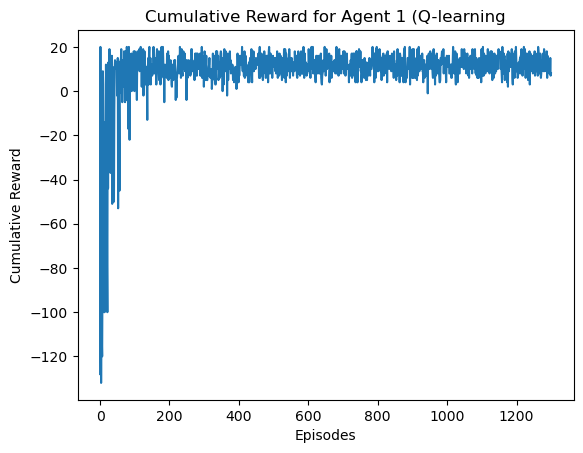

In [50]:
import numpy as np
import matplotlib.pyplot as plt
from env import StaticGridEnv

# Q-learning parameters
alpha = 0.8
gamma = 0.9
initial_epsilon = 0.2
epsilon_decay = 0.995
min_epsilon = 0.01
num_episodes = 1300
max_steps_per_episode = 100

# Initialize the environment with an increased goal reward
env = StaticGridEnv(seed=42)
env.goal_reward = 200

# Initialize Q-table
q_table = np.zeros((env.grid_size, env.grid_size, env.action_space))

# Metrics tracking
total_rewards = []
steps_per_episode = []
successful_episodes = 0

# Q-learning with adjustments
epsilon = initial_epsilon
for episode in range(num_episodes):
    state = env.reset()
    total_reward = 0
    for step in range(max_steps_per_episode):
        # Choose action based on epsilon-greedy policy
        if np.random.rand() < epsilon:
            action = np.random.randint(env.action_space)  # Explore: random action
        else:
            action = np.argmax(q_table[state[0], state[1]])  # Exploit: best action

        # Take the action and observe the outcome
        next_state, reward, done, _ = env.step(action)
        
        # Q-learning update rule
        best_next_action = np.argmax(q_table[next_state[0], next_state[1]])
        q_table[state[0], state[1], action] += alpha * (
            reward + gamma * q_table[next_state[0], next_state[1], best_next_action] - q_table[state[0], state[1], action]
        )

        # Update current state and cumulative reward
        state = next_state
        total_reward += reward

        if done:
            successful_episodes += 1
            break

    # Decay epsilon
    epsilon = max(min_epsilon, epsilon * epsilon_decay)

    # Track metrics
    total_rewards.append(total_reward)
    steps_per_episode.append(step + 1)

# Save the trained Q-table as a file to use in Task 3
np.save("task_1_q_table_teacher.npy", q_table)

# Calculate and display performance metrics
success_rate = (successful_episodes / num_episodes) * 100
average_reward = np.mean(total_rewards)
average_learning_speed = 1 / np.mean(steps_per_episode)

print(f"Success Rate: {success_rate:.2f}%")
print(f"Average Reward per Episode: {average_reward:.2f}")
print(f"Average Learning Speed (ALS): {average_learning_speed:.2f}")

# Plot total reward per episode
plt.plot(total_rewards)
plt.xlabel("Episodes")
plt.ylabel("Cumulative Reward")
plt.title("Cumulative Reward for Agent 1 (Q-learning")
plt.show()

# Close the environment
env.close()


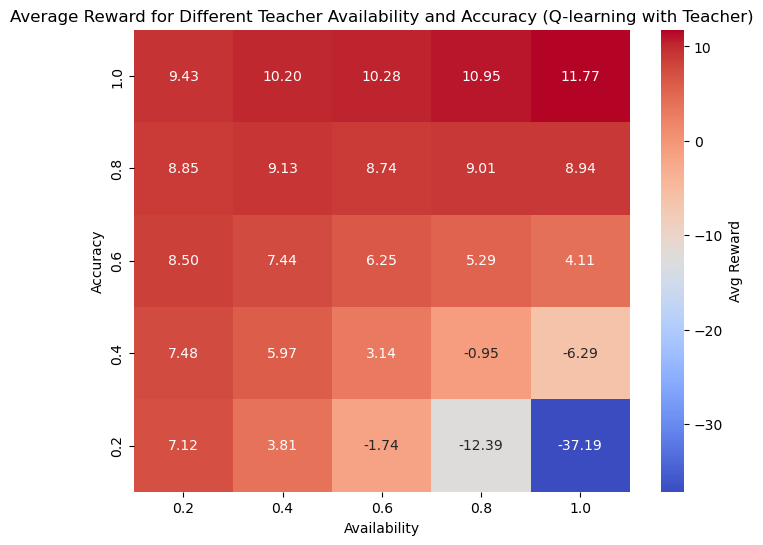

In [81]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from env import StaticGridEnv

# Load the Q-table trained in Task 1 to be used as the teacher
teacher_q_table = np.load("task_1_q_table_teacher.npy")

# Q-learning parameters for the student agent
alpha = 1
gamma = 0.8
initial_epsilon = 0.1
epsilon_decay = 0.995
min_epsilon = 0.01
num_episodes = 1000
max_steps_per_episode = 80

# Teacher parameters
availability_values = [0.2, 0.4, 0.6, 0.8, 1.0]
accuracy_values = [0.2, 0.4, 0.6, 0.8, 1.0]

# Initialize environment
env = StaticGridEnv(seed=42)
env.goal_reward = 150

# Function to train the student agent with teacher advice
def train_student_with_teacher(availability, accuracy):
    # Initialize Q-table for the student and metrics
    q_table = np.zeros((env.grid_size, env.grid_size, env.action_space))
    epsilon = initial_epsilon
    total_rewards = []
    steps_per_episode = []
    successful_episodes = 0

    for episode in range(num_episodes):
        state = env.reset()
        total_reward = 0
        for step in range(max_steps_per_episode):
            # Teacher advice based on availability and accuracy
            if np.random.rand() < availability:
                if np.random.rand() < accuracy:
                    # Correct advice: Use teacher's best action
                    action = np.argmax(teacher_q_table[state[0], state[1]])
                else:
                    # Incorrect advice: Take a random action
                    action = np.random.randint(env.action_space)
            else:
                # No teacher advice: follow epsilon-greedy policy
                if np.random.rand() < epsilon:
                    action = np.random.randint(env.action_space)
                else:
                    action = np.argmax(q_table[state[0], state[1]])

            next_state, reward, done, _ = env.step(action)
            best_next_action = np.argmax(q_table[next_state[0], next_state[1]])
            q_table[state[0], state[1], action] += alpha * (
                reward + gamma * q_table[next_state[0], next_state[1], best_next_action] - q_table[state[0], state[1], action]
            )

            state = next_state
            total_reward += reward

            if done:
                successful_episodes += 1
                break

        epsilon = max(min_epsilon, epsilon * epsilon_decay)
        total_rewards.append(total_reward)
        steps_per_episode.append(step + 1)

    # Calculate performance metrics
    success_rate = (successful_episodes / num_episodes) * 100
    avg_reward = np.mean(total_rewards)
    avg_learning_speed = 1 / np.mean(steps_per_episode)

    return avg_reward, success_rate, avg_learning_speed

# Run experiments and collect results
results = []
for availability in availability_values:
    for accuracy in accuracy_values:
        avg_reward, success_rate, avg_learning_speed = train_student_with_teacher(availability, accuracy)
        results.append({
            "Availability": availability,
            "Accuracy": accuracy,
            "Avg Reward": avg_reward,
            "Success Rate (%)": success_rate,
            "Avg Learning Speed": avg_learning_speed
        })


# Convert results to DataFrame for analysis
df_results = pd.DataFrame(results)

# Create a pivot table for heatmap using Average Reward
heatmap_data = df_results.pivot(index="Accuracy", columns="Availability", values="Avg Reward")
heatmap_data = heatmap_data.sort_index(ascending=False)  # Sort Accuracy in descending order for y-axis

# Plot the heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(
    heatmap_data,
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    cbar_kws={'label': 'Avg Reward'}
)
plt.title("Average Reward for Different Teacher Availability and Accuracy (Q-learning with Teacher)")
plt.xlabel("Availability")
plt.ylabel("Accuracy")
plt.show()


In [52]:
task_3_df = pd.DataFrame(results)
task_3_df.to_csv("task_3_results.csv", index=False)

Success Rate: 99.00%
Average Reward per Episode: 7.68
Average Learning Speed (ALS): 0.08


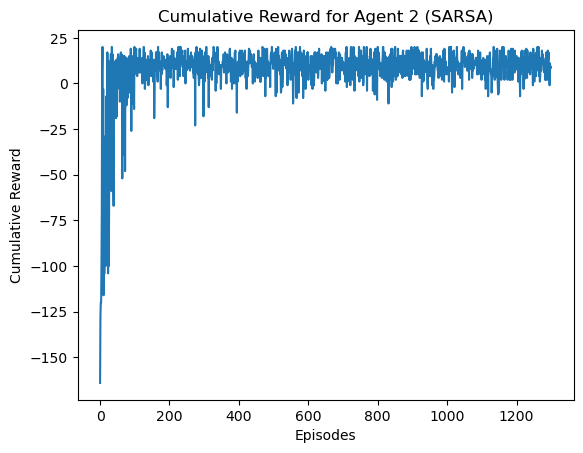

In [54]:
import numpy as np
import matplotlib.pyplot as plt
from env import StaticGridEnv

# SARSA parameters
alpha = 0.9  # Learning rate
gamma = 0.9  # Discount factor
epsilon = 0.1  # Exploration rate
num_episodes = 1300  # Number of episodes for training
max_steps_per_episode = 100  # Max steps per episode

# Initialize the environment
env = StaticGridEnv(seed=42)
q_table = np.zeros((env.grid_size, env.grid_size, env.action_space))  # Q-table

# Metrics tracking
total_rewards = []  # Total rewards per episode
steps_per_episode = []  # Steps taken per episode
successful_episodes = 0  # Number of successful episodes (goal reached)

# SARSA algorithm
for episode in range(num_episodes):
    state = env.reset()
    total_reward = 0

    # Choose initial action using epsilon-greedy policy
    if np.random.rand() < epsilon:
        action = np.random.randint(env.action_space)
    else:
        action = np.argmax(q_table[state[0], state[1]])

    for step in range(max_steps_per_episode):
        # Take the action and observe the outcome
        next_state, reward, done, _ = env.step(action)

        # Choose next action using epsilon-greedy policy
        if np.random.rand() < epsilon:
            next_action = np.random.randint(env.action_space)
        else:
            next_action = np.argmax(q_table[next_state[0], next_state[1]])

        # SARSA update rule
        q_table[state[0], state[1], action] += alpha * (
            reward + gamma * q_table[next_state[0], next_state[1], next_action] - q_table[state[0], state[1], action]
        )

        # Update the current state and action
        state, action = next_state, next_action
        total_reward += reward

        # If goal is reached, end the episode
        if done:
            successful_episodes += 1
            break

    # Track metrics
    total_rewards.append(total_reward)
    steps_per_episode.append(step + 1)

# Save the trained Q-table for future use (for Task 4 or analysis)
np.save("task_2_sarsa_teacher_q_table.npy", q_table)

# Calculate and display performance metrics
success_rate = (successful_episodes / num_episodes) * 100
average_reward = np.mean(total_rewards)
average_learning_speed = 1 / np.mean(steps_per_episode)

print(f"Success Rate: {success_rate:.2f}%")
print(f"Average Reward per Episode: {average_reward:.2f}")
print(f"Average Learning Speed (ALS): {average_learning_speed:.2f}")

# Plot total reward per episode
plt.plot(total_rewards)
plt.xlabel("Episodes")
plt.ylabel("Cumulative Reward")
plt.title("Cumulative Reward for Agent 2 (SARSA)")
plt.show()

# Close the environment
env.close()


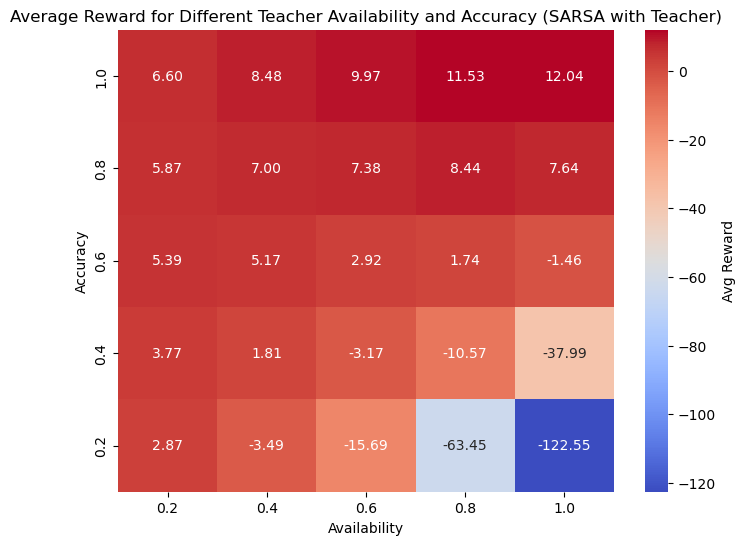

In [97]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from env import StaticGridEnv

# Load the SARSA-trained teacher Q-table
teacher_q_table = np.load("task_2_sarsa_teacher_q_table.npy")

# SARSA parameters for the student agent
alpha = 0.8
gamma = 0.9
initial_epsilon = 0.1
epsilon_decay = 0.995
min_epsilon = 0.01
num_episodes = 500
max_steps_per_episode = 100

# Teacher parameters
availability_values = [0.2, 0.4, 0.6, 0.8, 1.0]
accuracy_values = [0.2, 0.4, 0.6, 0.8, 1.0]

# Initialize environment
env = StaticGridEnv(seed=42)

# Define the function to provide teacher advice
def provide_teacher_advice(teacher_q_table, current_state, availability, accuracy):
    if np.random.rand() < availability:
        if np.random.rand() < accuracy:
            # Provide correct advice
            correct_action = np.argmax(teacher_q_table[current_state[0], current_state[1]])
            return correct_action
        else:
            # Provide incorrect advice
            correct_action = np.argmax(teacher_q_table[current_state[0], current_state[1]])
            possible_actions = list(range(teacher_q_table.shape[2]))
            possible_actions.remove(correct_action)
            return np.random.choice(possible_actions)
    return None  # No advice given

# Function to train the SARSA student agent with teacher advice
def train_sarsa_student_with_teacher(availability, accuracy):
    q_table = np.zeros((env.grid_size, env.grid_size, env.action_space))
    epsilon = initial_epsilon
    total_rewards = []
    steps_per_episode = []
    successful_episodes = 0

    for episode in range(num_episodes):
        state = env.reset()
        # Adjust goal reward based on accuracy for more nuanced results
        if accuracy <= 0.2: 
            env.goal_reward = 50
        elif accuracy <= 0.4:
            env.goal_reward = 100  # Lower goal reward for low accuracy
        elif accuracy <= 0.6:
            env.goal_reward = 150
        else:
            env.goal_reward = 200  # Higher goal reward for high accuracy

        # Initial action selection with epsilon-greedy policy
        if np.random.rand() < epsilon:
            action = np.random.randint(env.action_space)
        else:
            action = np.argmax(q_table[state[0], state[1]])

        total_reward = 0
        for step in range(max_steps_per_episode):
            # Get teacher advice
            teacher_advice = provide_teacher_advice(teacher_q_table, state, availability, accuracy)
            if teacher_advice is not None:
                action = teacher_advice  # Follow teacher's advice if given

            # Take the action and observe the outcome
            next_state, reward, done, _ = env.step(action)
            total_reward += reward

            # Choose next action using epsilon-greedy policy
            if np.random.rand() < epsilon:
                next_action = np.random.randint(env.action_space)
            else:
                next_action = np.argmax(q_table[next_state[0], next_state[1]])

            # SARSA update rule
            q_table[state[0], state[1], action] += alpha * (
                reward + gamma * q_table[next_state[0], next_state[1], next_action] - q_table[state[0], state[1], action]
            )

            q_min = np.min(q_table) 
            q_max = npm.max(q_table)

            q_table = (q_table - q_min) / (q_max - q_min)    

            state, action = next_state, next_action

            if done:
                successful_episodes += 1
                break

        # Decay epsilon
        epsilon = max(min_epsilon, epsilon * epsilon_decay)

        # Track metrics
        total_rewards.append(total_reward)
        steps_per_episode.append(step + 1)

    # Calculate performance metrics
    success_rate = (successful_episodes / num_episodes) * 100
    avg_reward = np.mean(total_rewards)
    avg_learning_speed = 1/np.mean(steps_per_episode)

    return avg_reward, success_rate, avg_learning_speed

# Run experiments and collect results
results = []
for availability in availability_values:
    for accuracy in accuracy_values:
        avg_reward, success_rate, avg_learning_speed = train_sarsa_student_with_teacher(availability, accuracy)
        results.append({
            "Availability": availability,
            "Accuracy": accuracy,
            "Avg Reward": avg_reward,
            "Success Rate (%)": success_rate,
            "Avg Learning Speed": avg_learning_speed
        })

# Convert results to DataFrame for analysis
df_results = pd.DataFrame(results)

# Create a pivot table for heatmap using Average Reward
heatmap_data = df_results.pivot(index="Accuracy", columns="Availability", values="Avg Reward")
heatmap_data = heatmap_data.sort_index(ascending=False)  # Sort Accuracy in descending order for y-axis

# Plot the heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(
    heatmap_data,
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    cbar_kws={'label': 'Avg Reward'}
)
plt.title("Average Reward for Different Teacher Availability and Accuracy (SARSA with Teacher)")
plt.xlabel("Availability")
plt.ylabel("Accuracy")
plt.show()


In [98]:
task_4_df = pd.DataFrame(results)
task_4_df.to_csv("task_4_results.csv", index=False)

In [99]:
import numpy as np
import pandas as pd
from utils import plot_comparison_with_baseline

# Assuming this is after your Q-learning training loop
# Save the Q-learning Q-table (model)
np.save("q_learning_q_table.npy", q_table)

# Save baseline metrics for Q-learning as a CSV
baseline_q_learning = {"Average Reward": [average_reward], "Success Rate": [success_rate], "Average Learning Speed": [average_learning_speed]}
baseline_q_learning_df = pd.DataFrame(baseline_q_learning)
baseline_q_learning_df.to_csv("baseline_q_learning.csv", index=False)

# Save the SARSA Q-table (model)
np.save("sarsa_q_table.npy", q_table)

# Save baseline metrics for SARSA as a CSV
baseline_sarsa = {"Average Reward": [average_reward], "Success Rate": [success_rate], "Average Learning Speed": [average_learning_speed]}
baseline_sarsa_df = pd.DataFrame(baseline_sarsa)
baseline_sarsa_df.to_csv("baseline_sarsa.csv", index=False)

from IPython.display import FileLink

# Provide a link to download the file directly in Jupyter Notebook
display(FileLink("baseline_q_learning.csv"))
display(FileLink("baseline_sarsa.csv"))

C:\Users\krlee\AssignmentAI2\baseline_q_learning.csv

C:\Users\krlee\AssignmentAI2\baseline_sarsa.csv

In [100]:
# Load the Q-learning Q-table as the teacher model
q_learning_q_table = np.load("q_learning_q_table.npy")

# Load baseline metrics for Q-learning from CSV
baseline_q_learning_df = pd.read_csv("baseline_q_learning.csv")
baseline_q_learning = tuple(baseline_q_learning_df.iloc[0].values)  # Convert to tuple

# Load the SARSA Q-table as the teacher model
sarsa_q_table = np.load("sarsa_q_table.npy")

# Load baseline metrics for SARSA from CSV
baseline_sarsa_df = pd.read_csv("baseline_sarsa.csv")
baseline_sarsa = tuple(baseline_sarsa_df.iloc[0].values)  # Convert to tuple

# Load DataFrames for Tasks 3 and 4 results (Q-learning and SARSA with teacher advice)
task_3_df = pd.read_csv("task_3_results.csv")  # Results for Q-learning with teacher advice
task_4_df = pd.read_csv("task_4_results.csv")  # Results for SARSA with teacher advice

In [101]:
task_3_df.rename(columns={
    "Average Reward": "Avg Reward",
    "Success Rate": "Success Rate (%)"
}, inplace=True)

# Print the columns to verify
print(task_3_df.columns)

Index(['Availability', 'Accuracy', 'Avg Reward', 'Success Rate (%)',
       'Avg Learning Speed'],
      dtype='object')


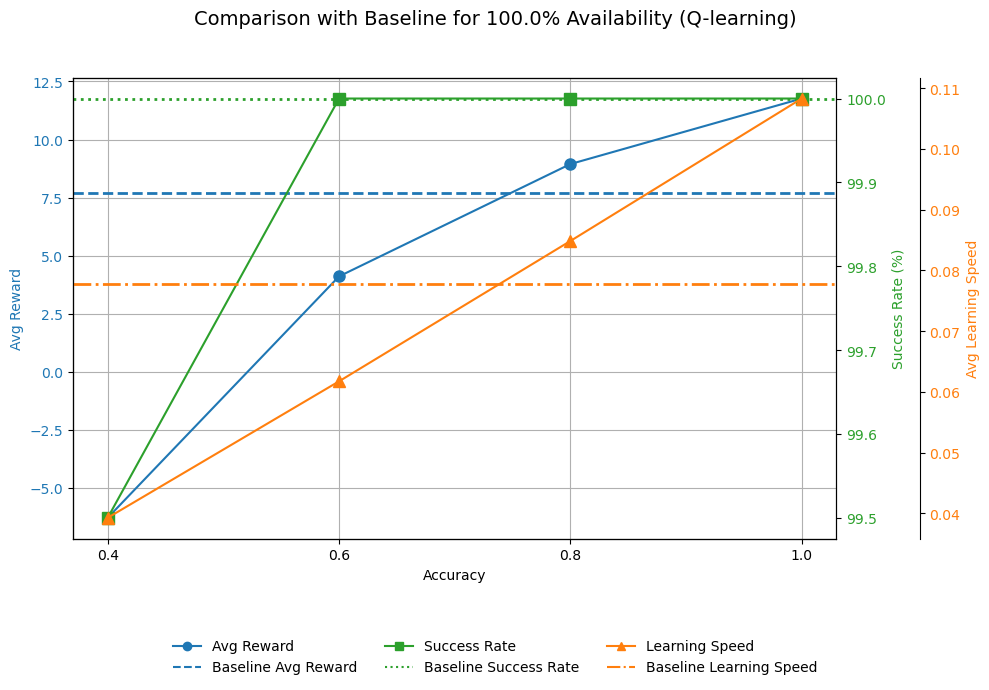

In [102]:
from utils import plot_comparison_with_baseline

# Plot for Q-learning with teacher advice at 100% availability
plot_comparison_with_baseline(
    availability=1.0,
    df_learning=task_3_df,
    baseline_learning=baseline_q_learning,
    accuracies=[0.4, 0.6, 0.8, 1.0],
    algorithm="Q-learning"
)


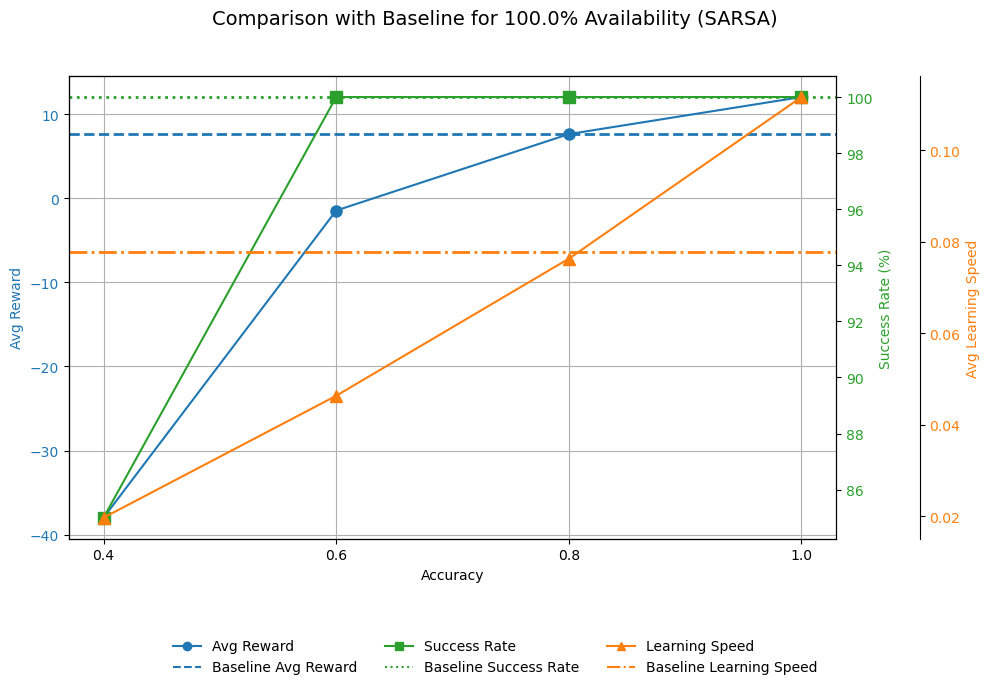

In [109]:
from utils import plot_comparison_with_baseline

# Plot for SARSA with teacher advice at 100% availability
plot_comparison_with_baseline(
    availability=1.0,
    df_learning=task_4_df,
    baseline_learning=baseline_sarsa,
    accuracies=[0.4, 0.6, 0.8, 1.0],
    algorithm="SARSA"
)
